In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

%matplotlib inline 

# Analyzing Language Change in an Online Community
#### Laura Suttle

## Abstract

asdasdasd

## Introduction and Goals

Online communities are important ways for people to discuss common interests. For those with particularly niche interests, these communities might provide the only outlet users have to share hobbies and fandoms. 

One community that fits this description is the forum located at http://www.reddit.com/r/rupaulsdragrace. This community focuses on the reality show Rupaul's Drag Race, which features drag queen competing to win the title "America's Next Drag Superstar." While the show has become more popular over the years, even winning an Emmy in 2016, the topic of the show, as well as its placement on a small cable-only network, results in a smaller, but extremely dedicated, fanbase. 

Those who regularly participate in the Drag Race community mention the strong drag culture that has permeated the discussion, including specific jargon, memes, and copypasta. This report explores whether the development of this "dialect" can be investigated using natural language processing. 

The main goal of this report is to replicate a paper by Danescu-Niculescu-Mizil et al, 2013, which investigated lnaguage change in an online community. We will use trigram language models to investigate whether speakers on /r/rupaulsdragrace have, over time, adapted the speaking habits of other users. 

## Background

/r/rupaulsdragrace was founded in November 2011. Since its inception, it has grown to over 50,000 members. The data used in this analysis includes all comments on the forum posted between January 2012 and October 2016, a total of just over two millions unique comments. As described in the forum's "sidebar," which includes a description of the forum, /r/rupaulsdragrace is "A community dedicated to America's most popular drag competition." As such, comments focus specifically on topics centered around the reality show and not drag in general. 

While Rupaul's Drag Race has aired a total of ten seasons, the forum was not created until after the second season. The data for this analysis was pulled while the tenth season was still being aired. Due to this, the comments analyzed only include seven complete seasons and part of the most recent season. 

The forum shows strong seasonilty in activity. Unsurprisingly, as shown in the two figures below, more posts are made while seasons are being aired (showed in all charts as grey bars). In addition, more unique users comment while seasons are being aired. Despite the seasonality, the forum shows strong growth over time. 

In [3]:
# pulling data by months, so get a list of months
from datetime import date
from dateutil.relativedelta import relativedelta

d = date(2012,01,01)
drange = [(d + relativedelta(months=+x)).strftime('%s') for x in range(0, 58)]
drange3 = [(d + relativedelta(months=+x)) for x in range(0, 58)]

# pull in data by months
# THIS TAKES A WHILE

import textclean
import sqlite3 as lite

con = lite.connect('rpdr_comments/rpdr_comments.db')

# empty lists to store data we want to use
score = []
body = []
user = []
ids = []
new = []

with con:
    # for each month, get data
    for pair in [(drange[i], drange[i+1]) for i in range(len(drange)-1)]:
        cur = con.cursor()
        df = cur.execute("select id, c.author, score, body, user_type \
                            from comments as c \
                            left join \
                            (select author, 'new' as user_type from first_posts  \
                            WHERE created BETWEEN {d1} and {d2}) as t on c.author =t.author \
                            WHERE created_utc BETWEEN '{d1}' and '{d2}';".format(d1=pair[0], d2=pair[1]))
        out = df.fetchall()

        body.append(textclean.clean_text([x[3] for x in out]))
        score.append([x[2] for x in out])
        user.append([x[1] for x in out])
        ids.append([x[0] for x in out])
        new.append([x[4] for x in out])

# find unique users by month
unique_users = [set(x) for x in user]

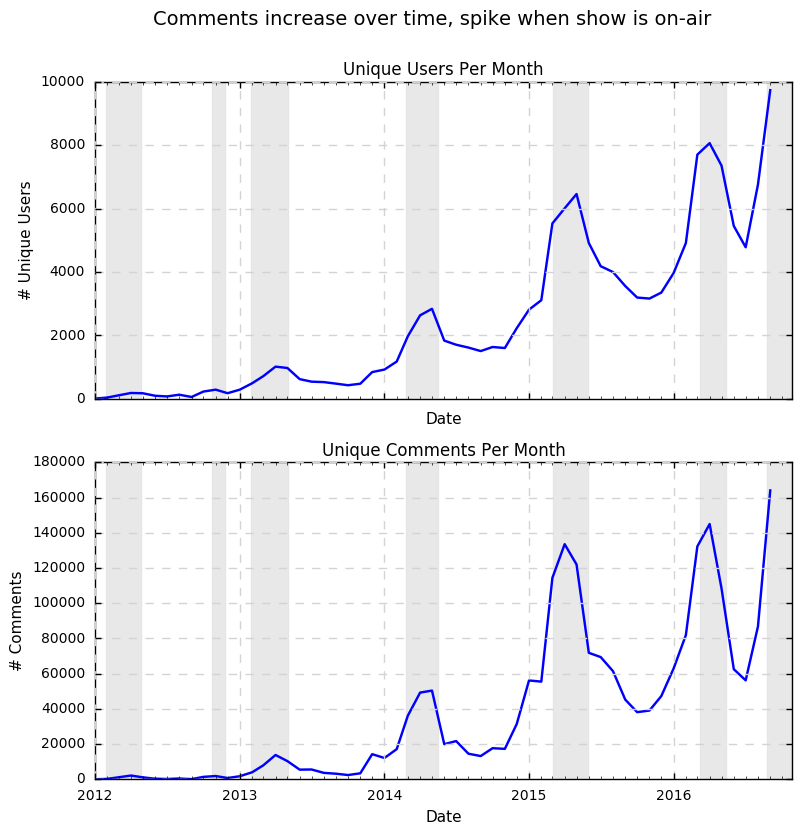

In [17]:
import report_plots
reload(report_plots)

# season dates that will be used for all charts
seasons = [(date(2012,01,30), date(2012,04,30)),
           (date(2012,10,22), date(2012,11,26)),
           (date(2013,01,28), date(2013,05,06)), 
           (date(2014,02,24), date(2014,05,19)), 
           (date(2015,03,02), date(2015,06,01)), 
           (date(2016,03,07), date(2016,05,16)), 
           (date(2016,8,25), date(2016,10,27))]

# plot basic descriptives for the subreddit
report_plots.descriptives(unique_users, body, drange3, seasons)

## Analysis Approach

The analysis used in this report is a replication of Danescu-Niculescu-Mizil et al, 2013, section 3.1. The authors followed the following procedure:

1. Get data for each month
2. Use 1000 of the posts to create a bi-gram language model with Laplace backoff for each month
3. Calculate the average cross-entropy for the posts not used to train the model, using the formula $$ H(p,SLM_{m(p)}) = -\frac{1}{N} \sum_{i} \log P_{SLM_{m(p)}}(b_{i}), $$ where $ P_{SLM_{m(p)}}(b_{i}) $ represents the probability of a bigram under each model for that month $m(p)$. 
4. Find posts from users that are new in that month. 

They found that, across both online communities they studies, that average cross-entropy dropped over time, indicating that users were speaking more like each other (more easily predictable by the model). They also found that new users had much larger cross-entropy than total users, with new users not showing a change over time. The conclusion was that new users come in not speaking like the rest of the forum and have to adapt, while the community over time is speaking more similarly to each other. 

We will follow that proceure in this study, with the exception of using a tri-gram language model with Katz smoothing. These models were copied from materials provided by the instructors of the course that this report was written for. Otherwise, the procedure is the same.

Due to the need to sample 1000 posts at each month, we are unable to use the first year of data due to a small sample. Below, before analyzing the data, we subset out posts from 2012, only looking at 2013 forward. 

In [5]:
#subset to only the months with > 4k comments
# this turns out to be 2013 or later

ccount = [len(x) for x in body]

score_s = score[13:]
body_s = body[13:]
user_s = user[13:]
ids_s = ids[13:]
new_s = new[13:]

unique_users_s = unique_users[13:]

In [18]:
# calculating the cross entropy per month
# THIS TAKES A WHILE

import vocab 
import ngram_lm
import itertools

reload(ngram_lm)
reload(vocab)

# model parameters
vocab_size = 20000
train_size = 1000
params = dict(kn=False, add_k=1.0, backoff=5) # Katz smoothing
max_length = 30

# empty lists to store scores and sentence lengths
scorel = []
lengths = []

# for each month
for text in body_s:
    
    # get training data
    split_idx = train_size

    train_sentences = text[:split_idx]
    dev_sentences = text[split_idx:]

    # build vocab for that month
    token_feed = (vocab.canonicalize_word(w) 
                      for w in itertools.chain.from_iterable([x.split() for x in text]))
    vocab_pruned = vocab.Vocabulary(token_feed, size=vocab_size)

    # pad data for the trigram model
    padded_sentences = (["<s>", "<s>"] + s.split() + ["</s>"] for s in train_sentences)
    token_feed = (vocab.canonicalize_word(w, wordset=vocab_pruned.word_to_id) 
              for w in itertools.chain.from_iterable(padded_sentences))

    # run trigram model for each month
    lm3 = ngram_lm.SmoothedTrigramLM(token_feed)

    padded_dev_sentences = [["<s>", "<s>"] + s.split() + ["</s>"] for s in dev_sentences]

    # get length and cross entropy for each comment in dev set
    lengths.append([len(x)-2 for x in padded_dev_sentences])
    scorel.append([lm3.score_seq(x, **params) * -1 for x in padded_dev_sentences])

# get average cross entropy per comment
avg_scores = [[(b) / (m) for b,m in zip(scorel[i], lengths[i])] for i in range(len(scorel))]

# split up scores for new and existing users
new_scores = []
old_scores = []

for j in range(len(new_s)):
    r = []
    s = []
    for i, x in enumerate(new_s[j][1000:]):
        if x is not None:
            r.append(i)
        else:
            s.append(i)
    new_scores.append(r)
    old_scores.append(s)  

avg_new_user_scores = [[avg_scores[j][i] for i in new_scores[j]] for j in range(len(avg_scores))]
avg_old_user_scores = [[avg_scores[j][i] for i in old_scores[j]] for j in range(len(avg_scores))]

# percent of posts by new users per month
# didn't end up using it
per_new = [round(float(len(new_user_scores[i]))/len(scorel[i])*100,2) for i in range(len(new_user_scores))]

## Results

The below chart shows the change in cross-entropy in /r/rupaulsdragrace over time. We replicate the overall finding of Danescu-Niculescu-Mizil et al, 2013: average cross-entropy of posts decreases over time. However, splitting between new and existing users, both groups are similar to the overall average. In other words, new users behave just like existing users, in terms of the average cross-entropy of their posts. 

One additional interesting observation is that there does not appear to be any distinct changes in cross-entropy across seasons. That is, despite the large influx of users and posts, entropy continues to drop over time. 

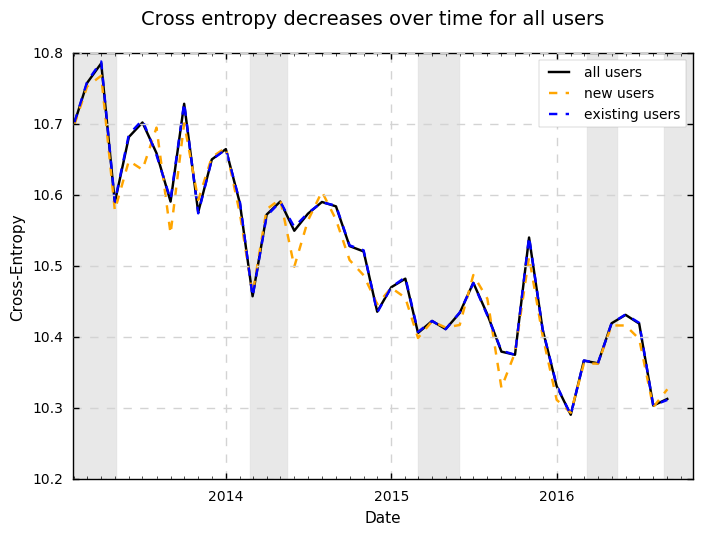

In [20]:
report_plots.results_plot(avg_scores, avg_new_user_scores, avg_old_user_scores, drange3, seasons)

One interesting property of reddit comments is that they are scored by other users. Due to this, we're able to test one potential mechanism for language change: whether or not comments that follow the linguistics conventions of the forum (that is, have a lower cross entropy), get more votes. Below we plot the correlation between scores and cross-entropy. There is no relationship between the two. 

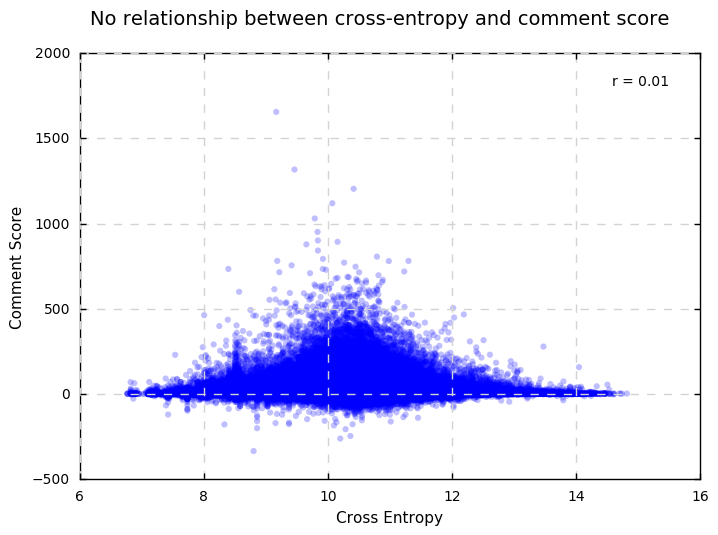

In [23]:
dev_scores = [x[1000:] for x in score_s]
y = [item for sublist in dev_scores for item in sublist]
x = [item for sublist in avg_scores for item in sublist]

report_plots.corr_plot(x,y)

## Conclusions

In conclusion, we were able to replicate the main finding of Danescu-Niculescu-Mizil, 2013. In our sample of posts from an online forum, we were able to used tri-gram language models to show that speakers speak more like the community over time. We found that, unlike the original paper, new users posting in their first month behave indistinguishably from the community at large. 

Why do our users behave differently that the beer forum posters in the reference paper? One likely explanation is the subject matter: while beer has a large appeal across people, drag and reality shows each have a smaller range of appeal. In addition, those who want to discuss a show such as Rupaul's Drag Race are likely already superfans and know much of the lingo and turns of phrases. Since Drag Race borrows heavily from drag and gay culture at large, it's also likely that users, usually coming from those communities, already have some of the speaking patterns down. 

## References


Danescu-Niculescu-Mizil, C., West, R., Jurafsky, D., Leskovec, J., & C. Potts. No country for old members: User lifecycle and linguistic change in online communities. ACM International Conference on World Wide Web (WWW), 2013.


Katz, S. M. Estimation of probabilities from sparse data for the language model component of a speech recognizer. IEEE Trans. on Acoustics, Speech, and Signal Processing, 1987.
